# Init libraries

In [36]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor,Grayscale,Compose,RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, Resize
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import time as time
import numpy as np
from IPython import display

# Load Dataset and convert to grayscale

In [37]:
# Dataset class for the ImageNet dataset extending the torchvision ImageNet class
class ImageNetDataset(ImageNet):
    # Constructor
    def __init__(self, root, split='train', transform=None):
        # Calling the constructor of the parent class
        super().__init__(root, split=split, transform=transform)
        

    # Getting the image and label at a given index
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image, label

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()
    

In [38]:
# Define transforms
#Train transforms
train_transform = Compose([
    ToTensor(),
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    Grayscale(num_output_channels=1),
    Resize((256, 256))
])
#Test transforms
val_transform = Compose([
    ToTensor(),
    Grayscale(num_output_channels=1),
    Resize((256, 256))
])
# Data loaders
root="./dataset/imagenet/"
train_dataset = ImageNetDataset(root, split='train', transform=train_transform)
val_dataset = ImageNetDataset(root, split='val', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

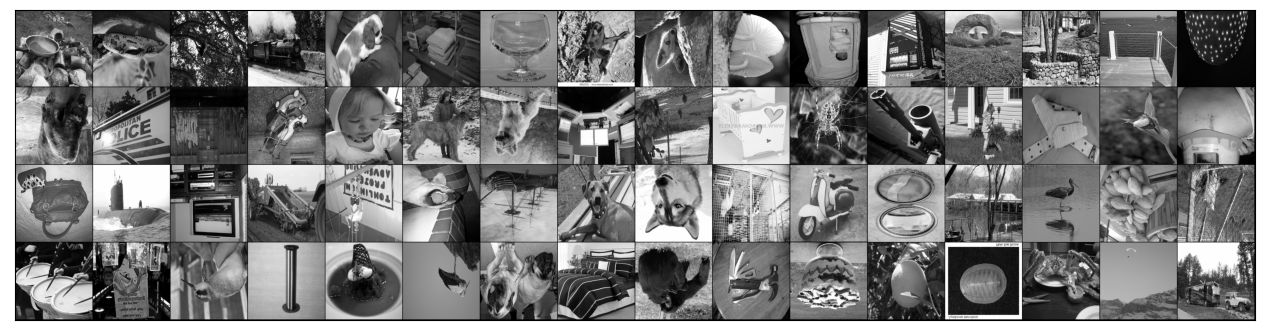

In [42]:
# Function to show a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

# UNET Autoencoder

In [49]:
# Start UNet autoencoder class implementation
class UNet(nn.Module):
    def __init__(self,encoded_space_dim):
        super().__init__()

        self.encoder_lin = nn.Sequential(
            # Encoder
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 1024, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.ReLU()
        )

        self.decoder_lin = nn.Sequential(
            # Decoder
            nn.ConvTranspose2d(1024, 512, 2, stride=2),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 2, stride=2),

            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),

        )
        
    def forward(self, x):
        x = self.encoder_lin(x)
        x = self.decoder_lin(x)
        return x
    
    # define shape of the encoded space
    def shape(self):
        return (64, 64)



In [50]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
unet = UNet(2)
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = val_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = UNet(img)
print('Encoded image shape:', img_enc.shape)

Original image shape: torch.Size([1, 1, 256, 256])


AttributeError: 'UNet' object has no attribute 'shape'